In [5]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import pickle

# ==========================================
# 1. KONFIGURASI SISTEM (CPU MODE)
# ==========================================
# Paksa TensorFlow menggunakan CPU agar stabil di Python 3.13
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print(f"Versi TensorFlow: {tf.__version__}")
print("Mode: CPU Only (Optimized for Stability)")

# Path Data (Pastikan folder ini berisi file .npy hasil convert_data.py)
DATA_DIR = r"C:\Users\robot\OneDrive\Documents\Rich\processed_data_uint8" 

CONFIG = {
    "IMG_SIZE": 112,
    "MAX_FRAMES": 20,
    "BATCH_SIZE": 32,
    "EPOCHS": 20,       # Bisa diturunkan ke 10-15 jika di CPU terasa lama
    "LEARNING_RATE": 1e-4
}

Versi TensorFlow: 2.20.0
Mode: CPU Only (Optimized for Stability)


In [6]:
# ==========================================
# 2. DEFINISI LAYER ATENSI (PROPOSED METHOD)
# ==========================================
@tf.keras.utils.register_keras_serializable()
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(TemporalAttention, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [7]:
# ==========================================
# 3. PREPARASI DATA (SPLIT 70:15:15)
# ==========================================
def load_dataset_info(data_path):
    all_files = []
    all_labels = []
    if not os.path.exists(data_path):
        print(f"❌ Error: Folder {data_path} tidak ditemukan!")
        return [], [], []

    class_names = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
    
    for label in class_names:
        folder = os.path.join(data_path, label)
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npy')]
        for f in files:
            all_files.append(f)
            all_labels.append(label)
    return all_files, all_labels, class_names

print("Sedang membaca struktur data...")
files, labels, class_names = load_dataset_info(DATA_DIR)

if len(files) > 0:
    lb = LabelBinarizer()
    y_encoded = lb.fit_transform(labels)
    
    # --- SPLIT TAHAP 1: Ambil Data Test (15%) ---
    # Data ini benar-benar "Ghaib" (Unseen) saat training
    X_temp, X_test, y_temp, y_test = train_test_split(
        files, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
    )
    
    # --- SPLIT TAHAP 2: Pecah Sisanya jadi Train (70%) & Validation (15%) ---
    # Sisa 85% dibagi lagi. 0.15 / 0.85 = ~0.1765
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
    )
    
    print(f"\n✅ Total Data: {len(files)}")
    print(f"   - Training   (70%): {len(X_train)} sampel")
    print(f"   - Validation (15%): {len(X_val)} sampel (Untuk Early Stopping)")
    print(f"   - Testing    (15%): {len(X_test)} sampel (Untuk Evaluasi Akhir Jurnal)")

    # --- PIPELINE DATA ---
    def load_npy_wrapper(file_path, label):
        def _load_numpy(fp):
            return np.load(fp.decode())
        video = tf.numpy_function(_load_numpy, [file_path], tf.uint8)
        video.set_shape([CONFIG["MAX_FRAMES"], CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], 3])
        video = tf.cast(video, tf.float32) / 255.0
        return video, label

    def create_dataset(paths, labels, is_train=True):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        if is_train:
            ds = ds.shuffle(1000)
        ds = ds.map(load_npy_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(CONFIG["BATCH_SIZE"])
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

    train_ds = create_dataset(X_train, y_train, is_train=True)
    val_ds = create_dataset(X_val, y_val, is_train=False)
    test_ds = create_dataset(X_test, y_test, is_train=False) # Data Uji Akhir

else:
    print("⚠️ Data kosong! Jalankan convert_data.py dulu.")

Sedang membaca struktur data...

✅ Total Data: 2000
   - Training   (70%): 1399 sampel
   - Validation (15%): 301 sampel (Untuk Early Stopping)
   - Testing    (15%): 300 sampel (Untuk Evaluasi Akhir Jurnal)


In [8]:
# ==========================================
# 4. BUILD & TRAINING MODEL
# ==========================================
def build_model(model_type, num_classes):
    # Backbone: MobileNetV2
    base = tf.keras.applications.MobileNetV2(
        input_shape=(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], 3),
        include_top=False, 
        weights='imagenet'
    )
    base.trainable = False # CPU optimization: Bekukan backbone
    
    cnn_extractor = tf.keras.Model(inputs=base.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(base.output))

    # Sequence Input
    inputs = tf.keras.layers.Input(shape=(CONFIG["MAX_FRAMES"], CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], 3))
    x = tf.keras.layers.TimeDistributed(cnn_extractor)(inputs)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Cabang Arsitektur
    if model_type == 'static':
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
    elif model_type == 'lstm':
        x = tf.keras.layers.LSTM(128)(x)
    elif model_type == 'attention':
        x = TemporalAttention()(x)

    # Classifier
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, outputs, name=model_type)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["LEARNING_RATE"]),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

# Loop Training 3 Model
history_dict = {}
models_list = ['static', 'lstm', 'attention']

print("\n--- MULAI PROSES TRAINING ---")

for m_type in models_list:
    print(f"\n{'='*40}")
    print(f"TRAINING MODEL: {m_type.upper()}")
    print(f"{'='*40}")
    
    model = build_model(m_type, len(class_names))
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds, # Pakai Validation Set (bukan Test Set)
        epochs=CONFIG["EPOCHS"],
        callbacks=callbacks,
        verbose=1
    )
    
    history_dict[m_type] = history.history
    model.save(f"bisindo_model_{m_type}.keras")

print("\n✅ Semua model selesai dilatih dan disimpan.")


--- MULAI PROSES TRAINING ---

TRAINING MODEL: STATIC


C:\Users\robot\AppData\Local\Temp\ipykernel_21596\3604349938.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.0586 - loss: 3.9099 - val_accuracy: 0.1661 - val_loss: 3.3585 - learning_rate: 1.0000e-04
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.1580 - loss: 3.2679 - val_accuracy: 0.3223 - val_loss: 3.0191 - learning_rate: 1.0000e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.2259 - loss: 3.0155 - val_accuracy: 0.4618 - val_loss: 2.7387 - learning_rate: 1.0000e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.3109 - loss: 2.7616 - val_accuracy: 0.5116 - val_loss: 2.4959 - learning_rate: 1.0000e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.3796 - loss: 2.5188 - val_accuracy: 0.6213 - val_loss: 2.2363 - learning_rate: 1.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.4525 - loss: 2.2717 - val_accuracy: 0.7243 - val_loss: 2.0079 - learning_rate: 1.0000e-04
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.5118 

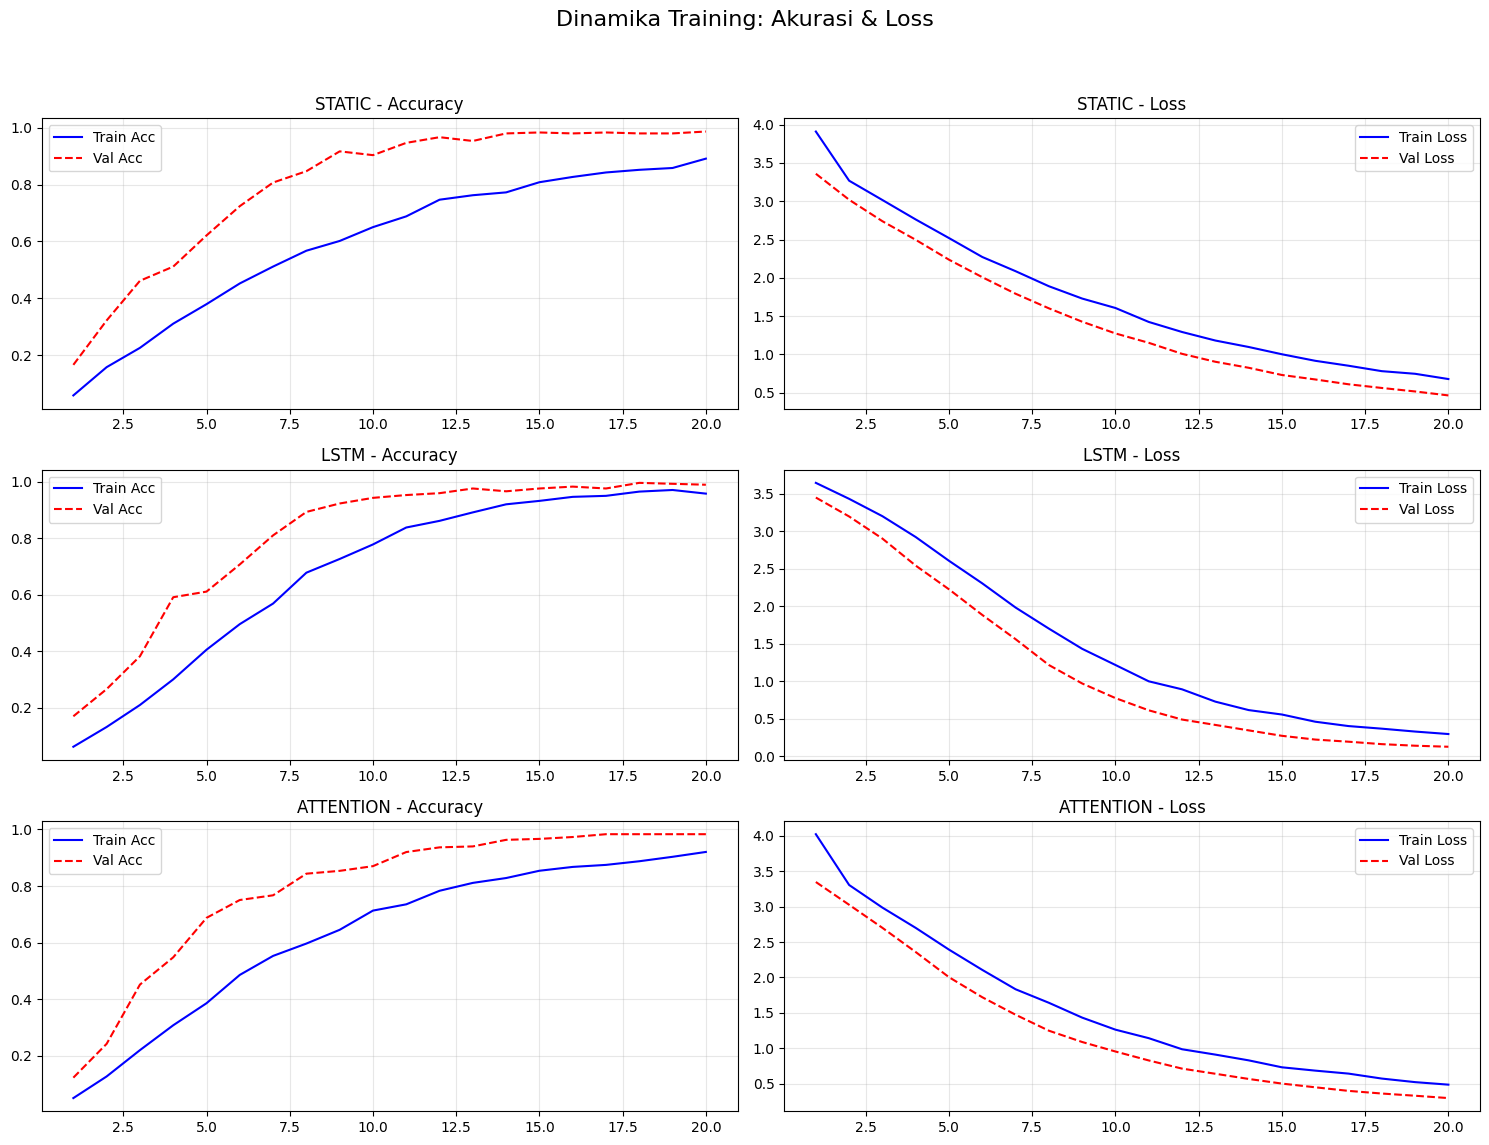

In [9]:
# ==========================================
# 5. VISUALISASI GRAFIK TRAINING
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Dinamika Training: Akurasi & Loss', fontsize=16)

for idx, m_type in enumerate(models_list):
    hist = history_dict[m_type]
    epochs = range(1, len(hist['accuracy']) + 1)
    
    # Plot Accuracy
    axes[idx, 0].plot(epochs, hist['accuracy'], 'b-', label='Train Acc')
    axes[idx, 0].plot(epochs, hist['val_accuracy'], 'r--', label='Val Acc')
    axes[idx, 0].set_title(f'{m_type.upper()} - Accuracy')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot Loss
    axes[idx, 1].plot(epochs, hist['loss'], 'b-', label='Train Loss')
    axes[idx, 1].plot(epochs, hist['val_loss'], 'r--', label='Val Loss')
    axes[idx, 1].set_title(f'{m_type.upper()} - Loss')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Usulan

✅ Grafik berhasil disimpan sebagai 'grafik_training_proposed.png'


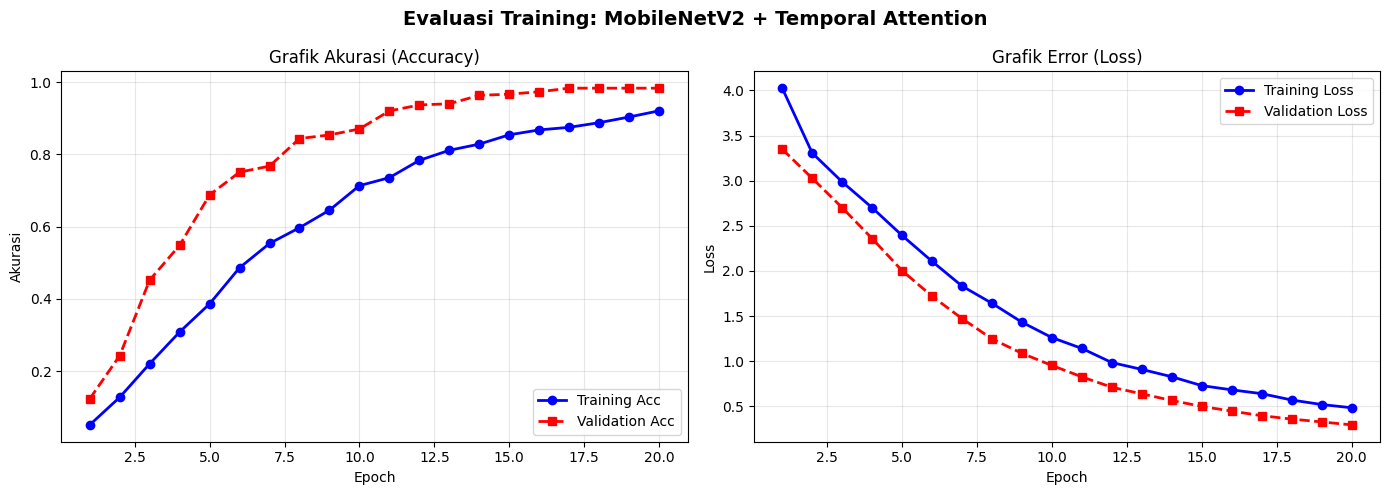

In [10]:
import matplotlib.pyplot as plt

# ==========================================
# VISUALISASI KHUSUS MODEL USULAN
# ==========================================

# Ambil data dari history
# (Pastikan variabel 'history' sudah ada dari proses training sebelumnya)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Buat Canvas (1 Baris, 2 Kolom)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Evaluasi Training: MobileNetV2 + Temporal Attention', fontsize=14, fontweight='bold')

# --- Plot 1: Akurasi ---
axes[0].plot(epochs, acc, 'b-o', linewidth=2, label='Training Acc')
axes[0].plot(epochs, val_acc, 'r--s', linewidth=2, label='Validation Acc')
axes[0].set_title('Grafik Akurasi (Accuracy)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Akurasi')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# --- Plot 2: Loss ---
axes[1].plot(epochs, loss, 'b-o', linewidth=2, label='Training Loss')
axes[1].plot(epochs, val_loss, 'r--s', linewidth=2, label='Validation Loss')
axes[1].set_title('Grafik Error (Loss)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Simpan gambar agar bisa ditaruh di jurnal/skripsi
plt.savefig('grafik_training_proposed.png', dpi=300) 
print("✅ Grafik berhasil disimpan sebagai 'grafik_training_proposed.png'")

plt.show()


--- EVALUASI PADA DATA TEST (UNSEEN DATA) ---
Menguji Model: STATIC...
Menguji Model: LSTM...
Menguji Model: ATTENTION...


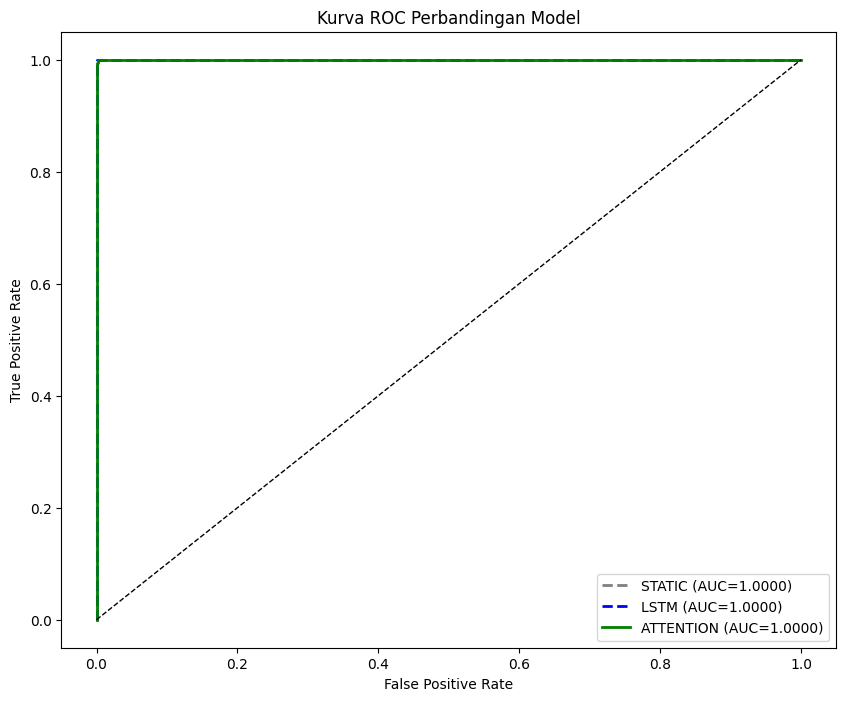


=== TABEL PERFORMA (METRIK UTAMA) ===
    Model  Accuracy  Precision  Recall  F1-Score
   STATIC    0.9967     0.9970  0.9967    0.9967
     LSTM    0.9900     0.9912  0.9900    0.9900
ATTENTION    0.9867     0.9882  0.9867    0.9866


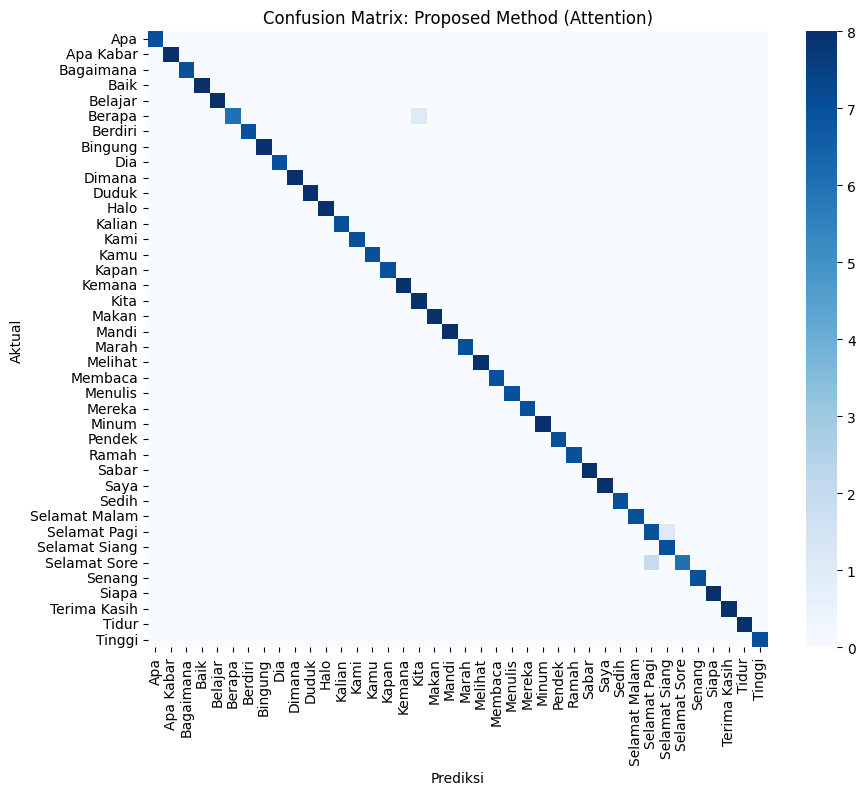

✅ Selesai! Data tersimpan di 'hasil_skripsi_final.csv'


In [11]:
# ==========================================
# 6. EVALUASI TEST SET (SINTA 2 STANDARDS)
# ==========================================
print("\n--- EVALUASI PADA DATA TEST (UNSEEN DATA) ---")

summary_metrics = []
y_true = np.argmax(y_test, axis=1) # Label asli data test
auc_scores = []

# Setup Plot ROC
plt.figure(figsize=(10, 8))
colors = ['grey', 'blue', 'green']
styles = ['--', '--', '-']

for m_type, color, style in zip(models_list, colors, styles):
    path_model = f"bisindo_model_{m_type}.keras"
    if not os.path.exists(path_model): continue
        
    print(f"Menguji Model: {m_type.upper()}...")
    model = tf.keras.models.load_model(path_model, custom_objects={'TemporalAttention': TemporalAttention})
    
    # Prediksi
    y_pred_probs = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 1. Metrik Dasar
    acc = np.mean(y_pred == y_true)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    summary_metrics.append({'Model': m_type.upper(), 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})
    
    # 2. ROC & AUC (Micro-Average)
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
    roc_auc = auc(fpr, tpr)
    auc_scores.append({'Model': m_type.upper(), 'AUC': roc_auc})
    
    plt.plot(fpr, tpr, color=color, linestyle=style, lw=2, label=f'{m_type.upper()} (AUC={roc_auc:.4f})')
    
    # 3. Confusion Matrix (Hanya Proposed Method)
    if m_type == 'attention':
        cm_matrix = confusion_matrix(y_true, y_pred)

# Finalisasi Plot ROC
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Kurva ROC Perbandingan Model')
plt.legend(loc="lower right")
plt.show()

# Tampilkan Tabel
df_metrics = pd.DataFrame(summary_metrics)
print("\n=== TABEL PERFORMA (METRIK UTAMA) ===")
print(df_metrics.round(4).to_string(index=False))

# Plot Confusion Matrix (Proposed)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_matrix, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Proposed Method (Attention)')
plt.xlabel('Prediksi'); plt.ylabel('Aktual')
plt.show()

# Simpan semua hasil
df_metrics.to_csv('hasil_skripsi_final.csv', index=False)
print("✅ Selesai! Data tersimpan di 'hasil_skripsi_final.csv'")